# Topic Modeling using LDA (Latent Dirichlet Allocation)

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# Initialize stopwords and lemmatizer outside the function
stop_words = set(stopwords.words('english'))
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    custom_stopwords = set(line.strip().lower() for line in f if line.strip())

stop_words.update(custom_stopwords)

# Special handling for forum text
forum_patterns = [
    (r'smilies?\w+\s?\w*\s?\d+', ''),  # Remove smiley codes
    (r'//.*', ''),                      # Remove code-like comments
    (r'\.{2,}', ' '),                   # Replace multiple dots
    (r'[^\w\s]', ' ')                   # Keep only words and spaces
]

lemmatizer = WordNetLemmatizer()

In [5]:
# Load the CSV file
file_path = "climate_posts_clean.csv"
try:
    df = pd.read_csv(file_path)
    # Get random sample of 250 entries
    sample_size = 500
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
    documents = df['text'].astype(str).tolist()
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

In [6]:
def preprocess_text(text, bigram_model=None):
    """
    Enhanced text preprocessing for LDA with bigram support:
    1. Comprehensive cleaning (URLs, emails, etc.)
    2. Advanced contraction handling
    3. Multi-stage filtering (stopwords, length, alphanumeric)
    4. Optional bigram processing
    """
    # Convert to string and lowercase
    text = str(text).lower()
    text = text.replace('\n', ' ').replace('\r', ' ')  # Remove line breaks

    # Advanced cleaning
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'\S*@\S*\s?', '', text)             # Emails
    text = re.sub(r'[^\w\s]|\d', ' ', text)            # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()           # Trim whitespace
    text = re.sub(r'\b(may|would|could|might)\b', '', text)  # Remove modals
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])
    text = re.sub(r'\b\w{1,3}\b', '', text)  # Remove very short words
    text = re.sub(r'\b(?:look|interesting|using|well|find)\b', '', text)
    text = re.sub(r'\b\w{5,20}\b', lambda x: x.group() if x.group() in {
        'climate', 'change', 'global', 'warming',
        'science', 'data', 'research'
    } else '', text)

    # Enhanced contraction handling
    contractions = {
        "don't": "do not", "can't": "cannot", "won't": "will not",
        "it's": "it is", "i'm": "i am", "you're": "you are",
        "they're": "they are", "that's": "that is", "there's": "there is",
        "he's": "he is", "she's": "she is", "what's": "what is"
    }
    for cont, expanded in contractions.items():
        text = text.replace(cont, expanded)

    # Tokenization and lemmatization
    try:
        tokens = word_tokenize(text)
        tokens = [
            lemmatizer.lemmatize(token)
            for token in tokens
            if (token not in stop_words and
                3 <= len(token) <= 25 and
                token.isalpha())
        ]

        # Apply bigram model if provided
        if bigram_model:
            tokens = bigram_model[tokens]

        return tokens
    except Exception as e:
        print(f"Error processing text: {e}")
        return []

# Preprocess documents
processed_docs = [preprocess_text(text) for text in documents]
processed_docs = [doc for doc in processed_docs if len(doc) > 0]

term_merges = {
    'climate': 'climate_science',
    'science': 'climate_science',
    'global': 'global_warming',
    'warming': 'global_warming',
    'fuel': 'fossil_fuels',
}

processed_docs = [
    [term_merges.get(word, word) for word in doc]
    for doc in processed_docs
]

# Create dictionary and corpus
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# # Test multiple topic numbers
# coherence_scores = []
# for num_topics in range(2, 8):
#     lda = LdaModel(
#         corpus=bow_corpus,
#         id2word=dictionary,
#         num_topics=num_topics,
#         passes=30
#     )
#     cm = CoherenceModel(
#         model=lda,
#         texts=processed_docs,
#         dictionary=dictionary,
#         coherence='c_v'
#     )
#     coherence_scores.append(cm.get_coherence())
#
# # Plot results
# import matplotlib.pyplot as plt
# plt.plot(range(2,8), coherence_scores)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.show()

# LDA Model with 3 topics
lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=3,
    random_state=42,
    passes=50,
    alpha='asymmetric'
)

# Evaluate LDA
coherence_model = CoherenceModel(
    model=lda_model,
    texts=processed_docs,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

# Calculate perplexity
perplexity = lda_model.log_perplexity(bow_corpus)  # This returns bound, need to convert
actual_perplexity = 2 ** (-perplexity)  # Convert to actual perplexity

print("\nLDA Topics:")
for idx, topic in lda_model.print_topics(-1, num_words=10):
    print(f"Topic {idx}: {topic}")
print(f"\nCoherence Score: {coherence_score:.4f}")
print(f"Perplexity: {actual_perplexity:.4f}")

# Interpretation notes
print("\nModel Evaluation Notes:")
print("- Higher coherence scores (closer to 1) indicate better topic quality")
print("- Lower perplexity scores indicate better model performance")
print("- Ideal model has high coherence and low perplexity")


LDA Topics:
Topic 0: 0.458*"climate_science" + 0.169*"data" + 0.113*"change" + 0.049*"heat" + 0.041*"nasa" + 0.033*"research" + 0.031*"land" + 0.026*"ipcc" + 0.022*"area" + 0.021*"temp"
Topic 1: 0.497*"fossil_fuels" + 0.192*"one" + 0.098*"ipcc" + 0.056*"nasa" + 0.037*"research" + 0.014*"past" + 0.012*"climate_science" + 0.011*"change" + 0.011*"global_warming" + 0.011*"lie"
Topic 2: 0.679*"global_warming" + 0.115*"climate_science" + 0.100*"change" + 0.056*"past" + 0.026*"research" + 0.005*"lie" + 0.005*"say" + 0.001*"temp" + 0.001*"heat" + 0.001*"land"

Coherence Score: 0.5353
Perplexity: 4.5078

Model Evaluation Notes:
- Higher coherence scores (closer to 1) indicate better topic quality
- Lower perplexity scores indicate better model performance
- Ideal model has high coherence and low perplexity


# Rule-Based Classification using VADER

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your dataset
data = pd.read_csv("climate_posts_clean.csv")

# Convert boolean sentiment to categorical labels
data['sentiment'] = data['positive_sentiment'].map({True: 'positive', False: 'negative'})

# Get 500 random samples (if you want to work with a subset)
sample_data = data.sample(n=1000, random_state=42)  # Remove this line if you want to use full dataset

# # First split: separate out 10% for validation
# train_dev_data, val_data = train_test_split(sample_data, test_size=0.1, random_state=42)
#
# # Second split: split remaining 90% into 80% train and 20% test (which becomes 72% and 18% of original)
# train_data, test_data = train_test_split(train_dev_data, test_size=0.2222, random_state=42)  #

# First split: separate out 10% for validation
train_dev_data, val_data = train_test_split(sample_data, test_size=0.1, random_state=42, stratify=sample_data['sentiment'])

# Second split: split remaining 90% into 80% train and 20% test (which becomes 72% and 18% of original)
train_data, test_data = train_test_split(train_dev_data, test_size=0.2222, random_state=42, stratify=train_dev_data['sentiment'])  # 0.2222 ≈ (20%/90%)

print(f"Training samples: {len(train_data)} ({len(train_data)/len(sample_data):.1%} of total)")
print(f"Testing samples: {len(test_data)} ({len(test_data)/len(sample_data):.1%} of total)")
print(f"Validation samples: {len(val_data)} ({len(val_data)/len(sample_data):.1%} of total)")

# Verify the splits add up correctly
assert len(train_data) + len(test_data) + len(val_data) == len(sample_data)

Training samples: 700 (70.0% of total)
Testing samples: 200 (20.0% of total)
Validation samples: 100 (10.0% of total)


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_predict(text):
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0 else 'negative'

# Apply VADER
vader_preds = test_data['text'].apply(vader_predict)


# Compare with your existing scores
test_data['vader_score'] = test_data['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
test_data['vader_pred'] = vader_preds

print("Vader Validation Performance:")
vader_val = val_data['text'].apply(vader_predict)
print(classification_report(val_data['sentiment'], vader_val))

print("\nVADER Performance:")
print(classification_report(test_data['sentiment'], vader_preds))

# Compare with your existing sentiment scores
print("\nComparison with existing scores:")
print(test_data[['text', 'raw_sentiment_score', 'positive_sentiment', 'vader_score', 'vader_pred']].head(10))

Vader Validation Performance:
              precision    recall  f1-score   support

    negative       0.97      0.67      0.79        54
    positive       0.71      0.98      0.83        46

    accuracy                           0.81       100
   macro avg       0.84      0.82      0.81       100
weighted avg       0.85      0.81      0.81       100


VADER Performance:
              precision    recall  f1-score   support

    negative       0.96      0.69      0.80       108
    positive       0.72      0.97      0.83        92

    accuracy                           0.81       200
   macro avg       0.84      0.83      0.81       200
weighted avg       0.85      0.81      0.81       200


Comparison with existing scores:
                                                    text  raw_sentiment_score  \
36267  Who Oh yeah I saw him working at Home Depot He...               0.5423   
20705  My god the climate change is even worse than w...              -0.5423   
54621  and any real

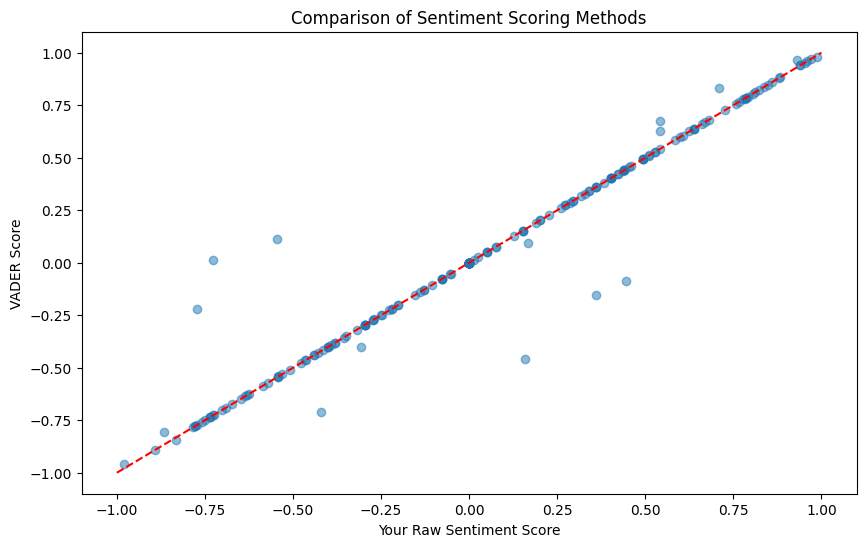

In [13]:
# Compare VADER with your raw_sentiment_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_data['raw_sentiment_score'], test_data['vader_score'], alpha=0.5)
plt.xlabel('Your Raw Sentiment Score')
plt.ylabel('VADER Score')
plt.title('Comparison of Sentiment Scoring Methods')
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect agreement line
plt.show()

# Machine-Based Classification using combined SVM and Logistic Regression

In [17]:
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import nltk

# Download required NLTK data
nltk.download(['vader_lexicon', 'wordnet', 'stopwords'])

# Enhanced preprocessing with negation handling
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)

    # Negation handling
    negation_words = ['not', 'no', 'never', 'none']
    words = text.split()
    for i, word in enumerate(words):
        if word in negation_words and i+1 < len(words):
            words[i+1] = "NOT_" + words[i+1]

    # Lemmatization and stopword removal
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Sentiment feature extractor
class SentimentFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        features = []
        for text in X:
            scores = sid.polarity_scores(str(text))
            features.append([scores['neg'], scores['neu'], scores['pos'], scores['compound']])
        return np.array(features)

# Initialize utilities
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

# Preprocess data
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
val_data['processed_text'] = val_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Create ensemble model
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    stop_words='english',
    min_df=3
)

# logreg = LogisticRegression(
#     class_weight='balanced',
#     C=0.1,
#     solver='lbfgs',
#     max_iter=1000,
#     random_state=42
# )

svm = SVC(
    class_weight='balanced',
    C=1,
    kernel='linear',
    probability=True,
    random_state=42
)

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            ngram_range=(1,3),
            stop_words='english',
            min_df=3
        )),
        ('sentiment', SentimentFeatures())
    ])),
    ('clf', svm)  # Using only SVM classifier
])

# Train
pipeline.fit(train_data['processed_text'], train_data['sentiment'])

# Evaluate
val_preds = pipeline.predict(val_data['processed_text'])
print("Validation Performance:")
print(classification_report(val_data['sentiment'], val_preds))

test_preds = pipeline.predict(test_data['processed_text'])
print("\nTest Performance:")
print(classification_report(test_data['sentiment'], test_preds))

# Error analysis
test_data['predictions'] = test_preds
misclassified = test_data[test_data['sentiment'] != test_data['predictions']]
print("\nMisclassified Examples:")
print(misclassified.sample(min(5, len(misclassified)))[['text', 'sentiment', 'predictions']])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Validation Performance:
              precision    recall  f1-score   support

    negative       0.92      0.89      0.91        54
    positive       0.88      0.91      0.89        46

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100


Test Performance:
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       108
    positive       0.87      0.90      0.89        92

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200


Misclassified Examples:
                                                    text sentiment predictions
4788   21156229 These guys have actually a http scien...  positive    negative
32359  If you do have the time or desire to look in t...  negative    positive
11667     Not since The Great Flood Now t